In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import os


def calculate_roc_auc(negative_scores, positive_scores):
    # Create labels, 0 for human-written, 1 for machine-generated
    labels = np.array([0] * len(negative_scores) + [1] * len(positive_scores))
    # Combine all scores
    scores = np.concatenate((negative_scores, positive_scores))
    # Calculate AUC
    auc = roc_auc_score(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    return auc, fpr, tpr

def print_tpr_target(fpr, tpr, target_fpr=0.01):
    fpr = np.array(fpr)
    tpr = np.array(tpr)
    
    if target_fpr < fpr[0]:
        print(f"TPR at {target_fpr*100}% FPR: {tpr[0] * 100:5.1f}% (target too low)")
        return
    
    if target_fpr > fpr[-1]:
        print(f"TPR at {target_fpr*100}% FPR: {tpr[-1] * 100:5.1f}% (target too high)")
        return
    
    idx = np.searchsorted(fpr, target_fpr, side='right')
    
    if fpr[idx-1] == target_fpr:
        tpr_value = tpr[idx-1]
    else:
        tpr_value = tpr[idx-1] + (target_fpr - fpr[idx-1]) * (tpr[idx] - tpr[idx-1]) / (fpr[idx] - fpr[idx-1])
    
    print(f"TPR at {target_fpr*100}% FPR: {tpr_value * 100:5.1f}%")




In [12]:
def get_auc(df, human_cname, cname, filter_human_score=False):
    human_scores = df[human_cname].to_numpy()
    positive_scores = df[cname].to_numpy()

    valid_indices = ~np.isnan(positive_scores)
    positive_scores = positive_scores[valid_indices]
    if filter_human_score:
        human_scores = human_scores[valid_indices]

    auc, fpr, tpr = calculate_roc_auc(human_scores, positive_scores)
    # print_tpr_target(fpr, tpr, target_fpr=0.01)
    return auc, len(positive_scores)


In [137]:
# def get_auc(df):
#     result_dict = {}
#     human_scores = df['human_score'].to_list()

#     for type_ in ['adaptive', 'paraphrased', 'spoofing']:
#         wm_scores = df[f'{type_}_watermarked_text_score'].to_list()
#         assert all(not np.isnan(score) for score in wm_scores), f'{type_} watermarked text scores contain NaN values'
#         auc_w, _, _ = calculate_roc_auc(human_scores, wm_scores)
#         result_dict[f'{type_}_auc'] = auc_w
#     return result_dict


## find common rows

In [92]:
def find_common_non_empty_indices(*series):
    """
    Given multiple pandas Series, find the common indices where all series have non-empty values.
    
    Parameters:
    *series: multiple pandas Series
    
    Returns:
    common_indices: list of common indices where all series have non-empty values
    """
    if not series:
        return []

    # Initialize common_indices with the indices of the first series
    common_indices = set(series[0].dropna().index)
    
    # Intersect with the indices of the remaining series
    for s in series[1:]:
        common_indices &= set(s.dropna().index)
    
    return list(common_indices)

# Example usage:
# common_indices = find_common_non_empty_indices(df['score1'], df['score2'], df['paraphrase_score'])
# print(common_indices)

In [93]:
import pandas as pd
import json

def load_jsonl_to_dataframe(filepath):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df


In [103]:
alpha = 2.0
delta0, delta = 0.1, 0.13
wm_dataset_names = ['c4', 'lfqa']
wm_model = 'Qwen2.5-7B-Instruct'  # Qwen2.5-7B-Instruct  Llama-3.1-8B-Instruct
score_columns_prefix = ['watermarked_text', 'paraphrase', 'sentiment_spoof', 'hate_spoof']

ours_prefix = ['adaptive', 'paraphrased', 'sentiment_spoofed', 'hate_spoofed']
ours_column_map = [f'{prefix}_watermarked_text_score' for prefix in ours_prefix]
ours_column_map = {k: v for k, v in zip(score_columns_prefix, ours_column_map)}

adaptive_prefix = ['adaptive', 'paraphrased', 'sentiment_spoofed', 'hate_spoofed']
adaptive_column_map = [f'{prefix}_watermarked_text_score' for prefix in adaptive_prefix]
adaptive_column_map = {k: v for k, v in zip(score_columns_prefix, adaptive_column_map)}

kgw_unigram_column_map = [f'{prefix}_score' for prefix in score_columns_prefix]
kgw_unigram_column_map = {k: v for k, v in zip(score_columns_prefix, kgw_unigram_column_map)}

postmark_column_map = [f'{prefix}_score' for prefix in score_columns_prefix]
postmark_column_map[0] = 'score2'
postmark_column_map = {k: v for k, v in zip(score_columns_prefix, postmark_column_map)}

results = []
for wm_dataset in wm_dataset_names:
    print(f'Processing {wm_dataset} dataset')
    # Load the results
    # ## ours
    # filepath = rf"/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-{wm_model}/wm-{wm_dataset}-alpha{alpha}-delta{delta0}|{delta}.csv"
    # df_ours = pd.read_csv(filepath)
    # ## adaptive
    # filepath = rf"/blue/buyuheng/li_an.ucsb/projects/baselines/adaptive-text-watermark/outputs/wm-model-{wm_model}/wm-{wm_dataset}-alpha{alpha}-delta{delta0}|{delta}.csv"
    # df_adaptive = pd.read_csv(filepath)
    ## KGW
    filepath = rf"/blue/buyuheng/li_an.ucsb/projects/baselines/lm-watermarking/results/wm-model-{wm_model}/{wm_dataset}.csv"
    df_kgw = pd.read_csv(filepath)
    ## Unigram
    filepath = rf"/blue/buyuheng/li_an.ucsb/projects/baselines/Unigram-Watermark/results/wm-model-{wm_model}/{wm_dataset}_strength_2.0_frac_0.5_len_300.csv"
    df_unigram = pd.read_csv(filepath)
    ## PostMark
    filepath = rf"/blue/buyuheng/li_an.ucsb/projects/baselines/PostMark/results/{wm_dataset}_0.06_score.jsonl"
    df_postmark = load_jsonl_to_dataframe(filepath)

    for prefix in score_columns_prefix:
        # Find the common indices where all scores are non-empty
        common_indices = find_common_non_empty_indices(df_ours[ours_column_map[prefix]], df_adaptive[adaptive_column_map[prefix]], df_kgw[kgw_unigram_column_map[prefix]], df_unigram[kgw_unigram_column_map[prefix]], df_postmark[postmark_column_map[prefix]])

        # Compute AUC for each method
        ours_auc, _, _ = calculate_roc_auc(df_ours['human_score'], df_ours[ours_column_map[prefix]][common_indices])
        adaptive_auc, _, _ = calculate_roc_auc(df_adaptive['human_score'], df_adaptive[adaptive_column_map[prefix]][common_indices])
        kgw_auc, _, _ = calculate_roc_auc(df_kgw['human_score'], df_kgw[kgw_unigram_column_map[prefix]][common_indices])
        unigram_auc, _, _ = calculate_roc_auc(df_unigram['human_score'], df_unigram[kgw_unigram_column_map[prefix]][common_indices])
        postmark_auc, _, _ = calculate_roc_auc(df_postmark['score1'], df_postmark[postmark_column_map[prefix]][common_indices])

        result_dict = {
            'wm_dataset': wm_dataset,
            'score_type': prefix,
            'num_valid_rows': len(common_indices),
            'ours_auc': ours_auc,
            'adaptive_auc': adaptive_auc,
            'kgw_auc': kgw_auc,
            'unigram_auc': unigram_auc,
            'postmark_auc': postmark_auc
        }
        results.append(result_dict)




Processing c4 dataset
Processing lfqa dataset


In [104]:
root_path = r"/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs"

results = pd.DataFrame(results)
# results.to_csv(os.path.join(root_path, 'main_results.csv'), index=False)
results

,wm_dataset,score_type,num_valid_rows,ours_auc,adaptive_auc,kgw_auc,unigram_auc,postmark_auc
0,c4,watermarked_text,198,0.993409,0.999722,0.967083,0.903750,0.999899
1,c4,paraphrase,194,0.810554,0.703209,0.566985,0.580490,0.888763
2,c4,sentiment_spoof,128,0.278945,0.968203,0.884375,0.830762,0.941191
3,c4,hate_spoof,198,0.298093,0.999091,0.965644,0.869192,0.998662
4,lfqa,watermarked_text,82,0.994329,1.000000,0.992134,0.978192,0.998963
5,lfqa,paraphrase,76,0.786151,0.714342,0.563980,0.486533,0.880954
6,lfqa,sentiment_spoof,43,0.362558,0.992791,0.925116,0.812585,0.939302
7,lfqa,hate_spoof,82,0.316494,1.000000,0.992073,0.961836,0.995701


## ours auc

In [142]:
import os
import re
import glob

root_path = "/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/"

wm_dataset_names = ['c4', 'lfqa']
is_prefix_ablation = False
prefix_ablation_folder = 'prefix-wm/' if is_prefix_ablation else ''
score_columns_prefix = ['adaptive', 'paraphrased', 'sentiment_spoofed', 'hate_spoofed', 'latter_sentiment_spoofed']
score_columns = [f'{prefix}_watermarked_text_score' for prefix in score_columns_prefix]


results = []
for wm_dataset_name in wm_dataset_names:
    print(f'------- wm on {wm_dataset_name} -------')
    pattern = re.compile(rf"""
        .*/c4/(?P<model_name>[^/]+)/64batch_15epochs/
        llama8gpt8-sent1-latter_sent1-fact0-hate1/
        loss_cl0.0-tl1.0-wneg999-margin0.9/
        wm-model-(?P<wm_model>[^/]+)/{prefix_ablation_folder}
        wm-{wm_dataset_name}-alpha(?P<alpha>[\d\.]+)-delta(?P<delta_0>[\d\.]+)\|(?P<delta>[\d\.]+)\.csv$
    """, re.VERBOSE)

    # get roc-auc results of mutual non-empty rows
    for filepath in glob.iglob(root_path + "/**/*.csv", recursive=True):
        match = pattern.match(filepath)
        if match:
            print(filepath)
            df = pd.read_csv(filepath)  
            auc_result_dict = {}
            for prefix, cname in zip(score_columns_prefix, score_columns):
                auc, num_valid_rows = get_auc(df, 'human_score', cname)
                auc_result_dict[f'{prefix}_auc'] = auc
                auc_result_dict[f'{prefix}_num_valid_rows'] = num_valid_rows

            result_dict = {'wm_dataset_name': wm_dataset_name}
            result_dict.update(match.groupdict())
            result_dict.update(auc_result_dict)
            results.append(result_dict)

------- wm on c4 -------
/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-Llama-3.1-8B-Instruct/wm-c4-alpha2.0-delta0.1|0.17.csv
/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-Llama-3.1-8B-Instruct/wm-c4-alpha2.0-delta0.2|0.5.csv
/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-Llama-3.1-8B-Instruct/wm-c4-alpha3.0-delta0.1|0.13.csv
/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.

In [143]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(root_path, 'roc_auc_results.csv'), index=False)

## adaptive

In [19]:
import os
import re
import glob

root_path = "/blue/buyuheng/li_an.ucsb/projects/baselines/adaptive-text-watermark/outputs/wm-model-Llama-3.1-8B-Instruct"

wm_dataset_names = ['c4', 'lfqa']
score_columns_prefix = ['adaptive', 'paraphrased', 'sentiment_spoofed', 'hate_spoofed']
score_columns = [f'{prefix}_watermarked_text_score' for prefix in score_columns_prefix]

results = []
for wm_dataset_name in wm_dataset_names:
    print(f'------- wm on {wm_dataset_name} -------')
    pattern = re.compile(rf"""
        .*/wm-{wm_dataset_name}-alpha(?P<alpha>[\d\.]+)-delta(?P<delta_0>[\d\.]+)\|(?P<delta>[\d\.]+)\.csv$
    """, re.VERBOSE)
    for filepath in glob.iglob(root_path + "/**/*.csv", recursive=True):
            match = pattern.match(filepath)
            if match:
                # print(filepath)
                # print(match.groupdict())
                df = pd.read_csv(filepath)
                auc_result_dict = {}
                for prefix, cname in zip(score_columns_prefix, score_columns):
                    auc, num_valid_rows = get_auc(df, 'human_score', cname)
                    auc_result_dict[f'{prefix}_auc'] = auc
                    auc_result_dict[f'{prefix}_num_valid_rows'] = num_valid_rows
                
                result_dict = {'wm_dataset_name': wm_dataset_name}
                result_dict.update(match.groupdict())
                result_dict.update(auc_result_dict)
                results.append(result_dict)

------- wm on c4 -------
------- wm on lfqa -------


In [21]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(root_path, 'roc_auc_results.csv'), index=False)

## KGW

In [ ]:
root_path = "/blue/buyuheng/li_an.ucsb/projects/baselines/lm-watermarking/results"

wm_dataset_names = ['c4', 'lfqa']
score_columns_prefix = ['watermarked_text', 'paraphrase', 'sentiment_spoof', 'hate_spoof']
score_columns = [f'{prefix}_score' for prefix in score_columns_prefix]

results = []
for wm_dataset in wm_dataset_names:
    filepath = rf"{root_path}/{wm_dataset}.csv"
    df = pd.read_csv(filepath)
    auc_result_dict = {}
    for prefix, cname in zip(score_columns_prefix, score_columns):
        auc, num_valid_rows = get_auc(df, 'human_score', cname)
        auc_result_dict[f'{prefix}_auc'] = auc
        auc_result_dict[f'{prefix}_num_valid_rows'] = num_valid_rows
    
    result_dict = {'wm_dataset_name': wm_dataset}
    result_dict.update(auc_result_dict)
    results.append(result_dict)

In [13]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(root_path, 'roc_auc_results.csv'), index=False)

In [14]:
results

,wm_dataset_name,watermarked_text_auc,watermarked_text_num_valid_rows,paraphrase_auc,paraphrase_num_valid_rows,sentiment_spoof_auc,sentiment_spoof_num_valid_rows,hate_spoof_auc,hate_spoof_num_valid_rows
0,c4,0.998138,200,0.668065,199,0.960103,194,0.997275,200
1,lfqa,0.999575,200,0.701412,200,0.976577,168,0.999350,200


## Unigram

In [26]:
import re
import glob

root_path = "/blue/buyuheng/li_an.ucsb/projects/baselines/Unigram-Watermark/results"

wm_dataset_names = ['c4']
wm_model_names = ['Llama-3.1-8B-Instruct']  # Qwen2.5-7B-Instruct
score_columns_prefix = ['watermarked_text', 'paraphrase', 'sentiment_spoof', 'hate_spoof']
score_columns = [f'{prefix}_score' for prefix in score_columns_prefix]

results = []
for wm_dataset in wm_dataset_names:
    for wm_model in wm_model_names:
        pattern = re.compile(rf"""
            .*/wm-model-{wm_model}/{wm_dataset}_strength_(?P<strength>[\d\.]+)_frac_0.5_len_300\.csv$
        """, re.VERBOSE)

        # get roc-auc results of mutual non-empty rows
        for filepath in glob.iglob(root_path + "/**/*.csv", recursive=True):
            match = pattern.match(filepath)
            if match:
                print(os.path.basename(filepath))
                df = pd.read_csv(filepath)
                auc_result_dict = {}
                for prefix, cname in zip(score_columns_prefix, score_columns):
                    auc, num_valid_rows = get_auc(df, 'human_score', cname)
                    auc_result_dict[f'{prefix}_auc'] = auc
                    auc_result_dict[f'{prefix}_num_valid_rows'] = num_valid_rows
                
                result_dict = {'wm_dataset_name': wm_dataset}
                result_dict.update(match.groupdict())
                result_dict.update(auc_result_dict)
                results.append(result_dict)

c4_strength_3.5_frac_0.5_len_300.csv
c4_strength_4.0_frac_0.5_len_300.csv
c4_strength_2.0_frac_0.5_len_300.csv
c4_strength_3.0_frac_0.5_len_300.csv
c4_strength_2.5_frac_0.5_len_300.csv


In [27]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(root_path, 'roc_auc_results.csv'), index=False)
results

,wm_dataset_name,strength,watermarked_text_auc,watermarked_text_num_valid_rows,paraphrase_auc,paraphrase_num_valid_rows,sentiment_spoof_auc,sentiment_spoof_num_valid_rows,hate_spoof_auc,hate_spoof_num_valid_rows
0,c4,3.5,0.999975,200,0.856470,199,0.996762,193,0.999950,200
1,c4,4.0,1.000000,200,0.892500,199,0.997165,194,1.000000,200
2,c4,2.0,0.993050,200,0.739372,199,0.948756,195,0.991812,200
3,c4,3.0,0.995463,200,0.819648,199,0.985234,192,0.995475,200
4,c4,2.5,0.999075,200,0.794598,199,0.982423,194,0.998850,200


## PostMark

In [43]:
import pandas as pd
import json

def load_jsonl_to_dataframe(filepath):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df


In [46]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

root_path = "/blue/buyuheng/li_an.ucsb/projects/baselines/PostMark/results"

wm_dataset_names = ['c4', 'lfqa']
ratio_values = [0.06, 0.08, 0.1, 0.12]
score_columns_prefix = ['watermarked_text', 'paraphrase', 'sentiment_spoof', 'hate_spoof']
score_columns = [f'{prefix}_score' for prefix in score_columns_prefix]
score_columns[0] = 'score2'

results = []
for wm_dataset in wm_dataset_names:
    print(f'------- wm on {wm_dataset} -------')
    for ratio in ratio_values:
        print(f"rotio: {ratio}")
        filepath = rf"{root_path}/{wm_dataset}_{ratio}_score.jsonl"
        df = load_jsonl_to_dataframe(filepath)
        auc_result_dict = {}
        for prefix, cname in zip(score_columns_prefix, score_columns):
            print(prefix, end=' ')
            auc, num_valid_rows = get_auc(df, 'score1', cname)
            auc_result_dict[f'{prefix}_auc'] = auc
            auc_result_dict[f'{prefix}_num_valid_rows'] = num_valid_rows
        
        result_dict = {'wm_dataset_name': wm_dataset, 'ratio': ratio}
        result_dict.update(auc_result_dict)
        results.append(result_dict)

------- wm on c4 -------
rotio: 0.06
watermarked_text TPR at 1.0% FPR:  99.5%
paraphrase TPR at 1.0% FPR:  32.7%
sentiment_spoof TPR at 1.0% FPR:  57.1%
hate_spoof TPR at 1.0% FPR:  94.9%
rotio: 0.08
watermarked_text TPR at 1.0% FPR: 100.0%
paraphrase TPR at 1.0% FPR:  60.1%
sentiment_spoof TPR at 1.0% FPR:  83.1%
hate_spoof TPR at 1.0% FPR:  99.5%
rotio: 0.1
watermarked_text TPR at 1.0% FPR: 100.0%
paraphrase TPR at 1.0% FPR:  50.5%
sentiment_spoof TPR at 1.0% FPR:  69.5%
hate_spoof TPR at 1.0% FPR:  98.5%
rotio: 0.12
watermarked_text TPR at 1.0% FPR: 100.0%
paraphrase TPR at 1.0% FPR:  64.0%
sentiment_spoof TPR at 1.0% FPR:  78.6%
hate_spoof TPR at 1.0% FPR: 100.0%
------- wm on lfqa -------
rotio: 0.06
watermarked_text TPR at 1.0% FPR:  97.5%
paraphrase TPR at 1.0% FPR:  28.4%
sentiment_spoof TPR at 1.0% FPR:  65.4%
hate_spoof TPR at 1.0% FPR:  90.4%
rotio: 0.08
watermarked_text TPR at 1.0% FPR: 100.0%
paraphrase TPR at 1.0% FPR:  42.3%
sentiment_spoof TPR at 1.0% FPR:  64.5%
hate_s

In [26]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(root_path, 'roc_auc_results.csv'), index=False)
results

,wm_dataset_name,ratio,watermarked_text_auc,watermarked_text_num_valid_rows,paraphrase_auc,paraphrase_num_valid_rows,sentiment_spoof_auc,sentiment_spoof_num_valid_rows,hate_spoof_auc,hate_spoof_num_valid_rows
0,c4,0.06,0.999899,198,0.890808,198,0.943138,192,0.998662,198
1,c4,0.08,0.999912,198,0.919306,198,0.980013,195,0.998965,198
2,c4,0.10,0.999899,199,0.934141,198,0.964505,197,0.999447,199
3,c4,0.12,0.999950,199,0.955393,197,0.977653,196,0.999698,199
4,lfqa,0.06,0.999264,197,0.872043,197,0.964784,185,0.994670,197
5,lfqa,0.08,1.000000,197,0.923668,197,0.962215,184,0.998756,197
6,lfqa,0.10,1.000000,197,0.937665,197,0.982231,186,0.997995,197
7,lfqa,0.12,0.999609,198,0.946256,197,0.986083,187,0.998043,198


# Ablation - prefix

In [37]:
root_path = "/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-Llama-3.1-8B-Instruct"

wm_dataset_names = ['c4', 'lfqa']
score_columns_prefix = ['sentiment_spoofed', 'latter_sentiment_spoofed']
score_columns = [f'{prefix}_watermarked_text_score' for prefix in score_columns_prefix]

results = []
for wm_dataset in wm_dataset_names:
    for is_ablation in [True, False]:
        ablation_folder = 'prefix-wm/' if is_ablation else ''
        filepath = rf"{root_path}/{ablation_folder}wm-{wm_dataset}-alpha2.0-delta0.2|0.5.csv"
        df = pd.read_csv(filepath)
        auc_result_dict = {}
        for prefix, cname in zip(score_columns_prefix, score_columns):
            auc, num_valid_rows = get_auc(df, 'human_score', cname)
            auc_result_dict[f'{prefix}_auc'] = round(auc, 4)
        
        result_dict = {'wm_dataset_name': wm_dataset, 'is_ablation': is_ablation}
        result_dict.update(auc_result_dict)
        results.append(result_dict)

results = pd.DataFrame(results)
results

,wm_dataset_name,is_ablation,sentiment_spoofed_auc,latter_sentiment_spoofed_auc
0,c4,True,0.4436,0.9870
1,c4,False,0.2532,0.3230
2,lfqa,True,0.3877,1.0000
3,lfqa,False,0.2721,0.2858


# Ablation - finetuned embedding

In [38]:
finetuned_path = r"/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-Llama-3.1-8B-Instruct"
ablation_path = r"/blue/buyuheng/li_an.ucsb/projects/baselines/adaptive-text-watermark/outputs/ablation-roberta-global"

wm_dataset_names = ['c4', 'lfqa']
score_columns_prefix = ['sentiment_spoofed', 'hate_spoofed']
score_columns = [f'{prefix}_watermarked_text_score' for prefix in score_columns_prefix]

results = []
for wm_dataset in wm_dataset_names:
    for setting, dir_path in zip(['finetuned', 'ablation'], [finetuned_path, ablation_path]):
        filepath = rf"{dir_path}/wm-{wm_dataset}-alpha2.0-delta0.2|0.5.csv"
        df = pd.read_csv(filepath)
        auc_result_dict = {}
        for prefix, cname in zip(score_columns_prefix, score_columns):
            auc, num_valid_rows = get_auc(df, 'human_score', cname)
            auc_result_dict[f'{prefix}_auc'] = round(auc, 4)
        
        result_dict = {'wm_dataset_name': wm_dataset, 'setting': setting}
        result_dict.update(auc_result_dict)
        results.append(result_dict)

results = pd.DataFrame(results)
results

,wm_dataset_name,setting,sentiment_spoofed_auc,hate_spoofed_auc
0,c4,finetuned,0.2532,0.2203
1,c4,ablation,0.9665,1.0000
2,lfqa,finetuned,0.2721,0.1929
3,lfqa,ablation,0.9318,1.0000


# Different watermarking model

In [41]:
import os
import re
import glob

root_path = "/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/"

wm_dataset_names = ['c4', 'lfqa']
is_prefix_ablation = False
prefix_ablation_folder = 'prefix-wm/' if is_prefix_ablation else ''
score_columns_prefix = ['adaptive', 'paraphrased', 'sentiment_spoofed', 'hate_spoofed']
score_columns = [f'{prefix}_watermarked_text_score' for prefix in score_columns_prefix]


results = []
for wm_dataset_name in wm_dataset_names:
    print(f'------- wm on {wm_dataset_name} -------')
    pattern = re.compile(rf"""
        .*/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/
        (?P<wm_model>[^/]+)/wm-{wm_dataset_name}-alpha(?P<alpha>[\d\.]+)-delta(?P<delta_0>[\d\.]+)\|(?P<delta>[\d\.]+)\.csv$
    """, re.VERBOSE)

    # get roc-auc results of mutual non-empty rows
    for filepath in glob.iglob(root_path + "/**/*.csv", recursive=True):
        match = pattern.match(filepath)
        if match:
            df = pd.read_csv(filepath)  
            auc_result_dict = {}
            for prefix, cname in zip(score_columns_prefix, score_columns):
                auc, num_valid_rows = get_auc(df, 'human_score', cname)
                auc_result_dict[f'{prefix}_auc'] = auc
                auc_result_dict[f'{prefix}_num_valid_rows'] = num_valid_rows

            result_dict = {'wm_dataset_name': wm_dataset_name}
            result_dict.update(match.groupdict())
            result_dict.update(auc_result_dict)
            results.append(result_dict)

------- wm on c4 -------
------- wm on lfqa -------


In [42]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(root_path, 'ablation_wm_models.csv'), index=False)
results

,wm_dataset_name,wm_model,alpha,delta_0,delta,adaptive_auc,adaptive_num_valid_rows,paraphrased_auc,paraphrased_num_valid_rows,sentiment_spoofed_auc,sentiment_spoofed_num_valid_rows,hate_spoofed_auc,hate_spoofed_num_valid_rows
0,c4,wm-model-Llama-3.1-8B-Instruct,2.0,0.2,0.5,0.994275,200,0.921739,197,0.253168,191,0.220300,200
1,c4,wm-model-Qwen2.5-7B-Instruct,2.0,0.2,0.5,0.993413,200,0.881244,197,0.251698,187,0.188863,200
2,lfqa,wm-model-Llama-3.1-8B-Instruct,2.0,0.2,0.5,0.990182,157,0.940687,157,0.272088,124,0.192949,157
3,lfqa,wm-model-Qwen2.5-7B-Instruct,2.0,0.2,0.5,0.985975,200,0.927550,199,0.187516,157,0.229087,200


# Radar

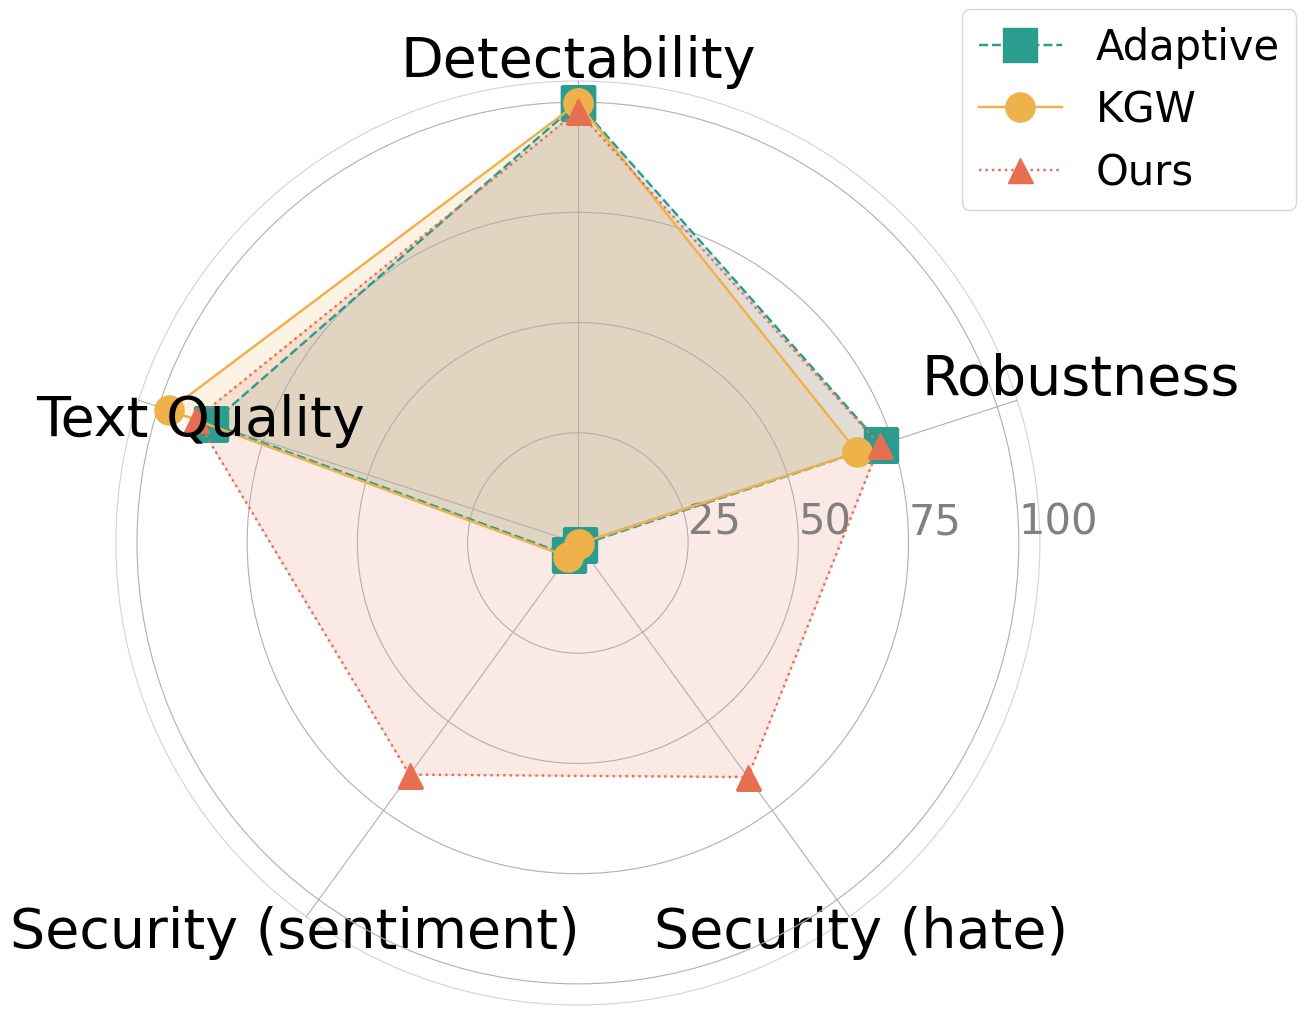

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

# delta = 0.13
data = {
    'method': ['Adaptive', 'KGW', 'Ours'],
    'Detectability': [99.78, 99.81, 98.02],
    'Robustness': [72.18, 66.67, 71.97],
    'Security (hate)': [100-99.35, 100-99.72, 100-34.38],
    'Security (sentiment)': [100-96.5, 100-96.14, 100-35.06],
    'Text Quality': [87.50, 97.45, 91.07],
}

df = pd.DataFrame(data)
metrics = df.columns[1:].tolist()

def plot_radar_chart(data, metrics, title=None):
    N = len(metrics)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    theta = np.concatenate([theta, [theta[0]]])
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    
    if title:
        ax.set_title(title, y=1.15, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines['polar'].set_zorder(1)
    ax.spines['polar'].set_color('lightgrey')
    
    color_palette = ['#2a9d8f', '#efb14a', '#e76f51']
    marker_styles = ['s', 'o', '^']
    marker_sizes = [25, 21, 18]
    line_styles = ['dashed', 'solid', 'dotted']
    font_size = 40

    for idx, (i, row) in enumerate(data.iterrows()):
        values = row[metrics].values.flatten().tolist()
        values = values + [values[0]]
        # ax.plot(theta, values, linewidth=1.75, linestyle='solid', label=row['method'], marker='o', markersize=5, color=color_palette[idx % len(color_palette)])
        ax.plot(
            theta, values,
            linewidth=1.75,
            linestyle=line_styles[idx % len(line_styles)],
            label=row['method'],
            marker=marker_styles[idx % len(marker_styles)],
            markersize=marker_sizes[idx % len(marker_sizes)],
            color=color_palette[idx % len(color_palette)], 
            zorder=3
        )
        ax.fill(theta, values, alpha=0.15, color=color_palette[idx % len(color_palette)])
    
    # Set xticks before modifying labels
    ax.set_xticks(theta[:-1])  # Ensure tick positions are set
    ax.set_xticklabels(metrics, color='black', size=font_size)

    # Manually reposition one specific label
    for label, angle in zip(ax.get_xticklabels(), theta[:-1]):
        if label.get_text() == metrics[1]:  # Adjust the label you want
            x = angle  # Increase radius slightly
            y = 120
            ax.text(x, y, label.get_text(), ha='center', va='center', fontsize=font_size, color='black')
            label.set_visible(False)  # Hide original label
        elif label.get_text() == metrics[4]:  # Adjust the label you want
            x = angle - 0.15  # Increase radius slightly
            y = 100 - 10
            ax.text(x, y, label.get_text(), ha='center', va='center', fontsize=font_size, color='black')
            label.set_visible(False)  # Hide original label

    plt.yticks([25, 50, 75, 100], ["25", "50", "75", "100"], color="grey", size=font_size-10)

    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size-10) 

    return fig


# Plot 
fig = plot_radar_chart(df, metrics)
plt.show()
plt.savefig('/blue/buyuheng/li_an.ucsb/projects/my_plot.pdf', format='pdf')


# Text quality - LLM judge

## Pairwise win rate

In [6]:
def print_win_rate(d):
    total = d['Total rows']
    for key, value in d.items():
        if key != 'Total rows':
            print(f"{key} win rate: {value/total*100:.2f}%")


In [7]:
# winrate

def calculate_win_rate(df):
    initial_count = len(df)
    df = df.dropna()
    dropped_count = initial_count - len(df)
    if dropped_count > 0:
        print(f'Number of rows dropped: {dropped_count}')
    total = len(df)
    result = {'Total rows': total}
    for criteria in df.columns:
        ours_wins = len(df[df[criteria] == 'ours'])
        result[criteria] = ours_wins
    
    print_win_rate(result)


In [ ]:
import pandas as pd

# baselines = ['kgw', 'unigram', 'adaptive', 'postmark']
baselines = ['kgw', 'unigram', 'postmark']
delta = 0.17
wm_dataset = 'c4'

for baseline in baselines:
    print(f'------- {baseline} -------')
    judge_result_path = f"/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/text_quality_judge/delta{delta}/{wm_dataset}_{baseline}_vs_ours.csv"
    df = pd.read_csv(judge_result_path)
    calculate_win_rate(df)



------- kgw -------


Number of rows dropped: 4
Text quality win rate: 32.14%
Relevance win rate: 42.35%
Overall win rate: 26.53%
------- unigram -------
Number of rows dropped: 4
Text quality win rate: 35.20%
Relevance win rate: 37.24%
Overall win rate: 28.06%
------- postmark -------
Number of rows dropped: 4
Text quality win rate: 63.27%
Relevance win rate: 70.92%
Overall win rate: 64.80%


## Avg Score

In [132]:
import pandas as pd

alpha = 2.0
delta0, delta = 0.1, 0.13
datasets = ['c4']
wm_model_names = ['Llama-3.1-8B-Instruct']  # Qwen2.5-7B-Instruct

methods_info = {
    "human": {"path": "/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-Llama-3.1-8B-Instruct/wm-{wm_dataset}-alpha2.0-delta0.2|0.5.csv", "column_name": "original_text"},
    "kgw": {"path": "/blue/buyuheng/li_an.ucsb/projects/baselines/lm-watermarking/results/wm-model-{wm_model}/{wm_dataset}.csv", "column_name": "watermarked_text"},
    "unigram": {"path": "/blue/buyuheng/li_an.ucsb/projects/baselines/Unigram-Watermark/results/wm-model-{wm_model}/{wm_dataset}_strength_2.0_frac_0.5_len_300.csv", "column_name": "watermarked_text"},
    "adaptive": {"path": "/blue/buyuheng/li_an.ucsb/projects/baselines/adaptive-text-watermark/outputs/wm-model-{wm_model}/wm-{wm_dataset}-alpha{alpha}-delta{delta0}|{delta}.csv", "column_name": "adaptive_watermarked_text"},
    "ours": {"path": "/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-{wm_model}/wm-{wm_dataset}-alpha{alpha}-delta{delta0}|{delta}.csv", "column_name": "adaptive_watermarked_text"},
    "postmark": {"path": "/blue/buyuheng/li_an.ucsb/projects/baselines/PostMark/results/c4_0.06.csv", "column_name": "text2"}
}


In [133]:
def map_value(value, from_min=1, from_max=3, to_min=0, to_max=100):
    # Ensure the value is within the original range
    if value < from_min or value > from_max:
        raise ValueError(f"Value {value} is out of the range [{from_min}, {from_max}]")

    # Perform the linear transformation
    mapped_value = (value - from_min) / (from_max - from_min) * (to_max - to_min) + to_min
    return round(mapped_value, 2)

# # Example usage:
# mapped_value = map_value(2.5)
# print(mapped_value)

In [134]:
import os

results = []
for wm_model in wm_model_names:
    for wm_dataset in datasets:
        for method, info in methods_info.items():
            if method == 'human':
                continue
            path_without_extension = os.path.splitext(info["path"].format(wm_model=wm_model, wm_dataset=wm_dataset, alpha=alpha, delta0=delta0, delta=delta))[0]
            path = path_without_extension + '_text_quality.csv'
            df = pd.read_csv(path)
            result_dict = {'wm_model': wm_model, 'wm_dataset': wm_dataset, 'method': method}
            result_dict['Text quality'] = df['Text quality'].mean()
            result_dict['Relevance'] = df['Relevance'].mean()
            result_dict['Overall'] = df['Overall'].mean()
            result_dict['Text quality (scaled)'] = map_value(df['Text quality'].mean())
            result_dict['Relevance (scaled)'] = map_value(df['Relevance'].mean())
            result_dict['Overall (scaled)'] = map_value(df['Overall'].mean())
            results.append(result_dict)

In [135]:
df = pd.DataFrame(results)
df_sorted = df.sort_values(by=['Overall', 'Relevance', 'Text quality'], ascending=False)
df_sorted

,wm_model,wm_dataset,method,Text quality,Relevance,Overall,Text quality (scaled),Relevance (scaled),Overall (scaled)
0,Llama-3.1-8B-Instruct,c4,kgw,2.948980,2.479592,2.571429,97.45,73.98,78.57
1,Llama-3.1-8B-Instruct,c4,unigram,2.897959,2.448980,2.535714,94.90,72.45,76.79
3,Llama-3.1-8B-Instruct,c4,ours,2.821429,2.377551,2.433673,91.07,68.88,71.68
2,Llama-3.1-8B-Instruct,c4,adaptive,2.750000,2.163265,2.224490,87.50,58.16,61.22
4,Llama-3.1-8B-Instruct,c4,postmark,2.229592,1.811224,1.892857,61.48,40.56,44.64


In [138]:
output_dir = rf"/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/text_quality_judge/delta{delta}"
df_sorted.to_csv(os.path.join(output_dir, 'text_quality_scores.csv'), index=False)


# PPL visualization

In [129]:
import pandas as pd

alpha = 2.0
delta0, delta = 0.1, 0.13
datasets = ['c4', 'lfqa']
wm_model_names = ['Llama-3.1-8B-Instruct']  # Qwen2.5-7B-Instruct

methods_info = {
    "human": {"path": "/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-Llama-3.1-8B-Instruct/wm-{wm_dataset}-alpha2.0-delta0.2|0.5.csv", "column_name": "original_text"},
    "kgw": {"path": "/blue/buyuheng/li_an.ucsb/projects/baselines/lm-watermarking/results/wm-model-{wm_model}/{wm_dataset}.csv", "column_name": "watermarked_text"},
    "unigram": {"path": "/blue/buyuheng/li_an.ucsb/projects/baselines/Unigram-Watermark/results/wm-model-{wm_model}/{wm_dataset}_strength_2.0_frac_0.5_len_300.csv", "column_name": "watermarked_text"},
    "adaptive": {"path": "/blue/buyuheng/li_an.ucsb/projects/baselines/adaptive-text-watermark/outputs/wm-model-{wm_model}/wm-{wm_dataset}-alpha{alpha}-delta{delta0}|{delta}.csv", "column_name": "adaptive_watermarked_text"},
    "ours": {"path": "/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/c4/twitter-roberta-base-sentiment/64batch_15epochs/llama8gpt8-sent1-latter_sent1-fact0-hate1/loss_cl0.0-tl1.0-wneg999-margin0.9/wm-model-{wm_model}/wm-{wm_dataset}-alpha{alpha}-delta{delta0}|{delta}.csv", "column_name": "adaptive_watermarked_text"},
    "postmark": {"path": "/blue/buyuheng/li_an.ucsb/projects/baselines/PostMark/results/c4_0.06.csv", "column_name": "text2"}
}


In [134]:
results = []
alpha = 3.0
delta0 = 0.1
delta_values = [0.13, 0.15, 0.17]

for wm_model in wm_model_names:
    for wm_dataset in datasets:
        for delta in delta_values:
            info = methods_info['ours']
            method = 'ours'
            path = info["path"].format(wm_model=wm_model, wm_dataset=wm_dataset, alpha=alpha, delta0=delta0, delta=delta)
            column_name = info["column_name"]
            column_name = f'ppl_{info[f"column_name"]}'
            df = pd.read_csv(path)
            ppl = round(df[column_name].median(), 2)
            tmp = {'wm_model': wm_model, 'wm_dataset': wm_dataset, 'delta': delta, 'ppl': ppl}
            results.append(tmp)

result_df = pd.DataFrame(results)
result_df = result_df.sort_values('delta')
result_df


,wm_model,wm_dataset,delta,ppl
0,Llama-3.1-8B-Instruct,c4,0.13,8.06
3,Llama-3.1-8B-Instruct,lfqa,0.13,9.54
1,Llama-3.1-8B-Instruct,c4,0.15,8.59
4,Llama-3.1-8B-Instruct,lfqa,0.15,9.55
2,Llama-3.1-8B-Instruct,c4,0.17,8.81
5,Llama-3.1-8B-Instruct,lfqa,0.17,9.83


In [100]:
results = []
for wm_model in wm_model_names:
    for wm_dataset in datasets:
        for method, info in methods_info.items():
            path = info["path"].format(wm_model=wm_model, wm_dataset=wm_dataset, alpha=alpha, delta0=delta0, delta=delta)
            column_name = info["column_name"]
            column_name = f'ppl_{info[f"column_name"]}'
            df = pd.read_csv(path)
            ppl = round(df[column_name].median(), 2)
            tmp = {'wm_model': wm_model, 'wm_dataset': wm_dataset, 'method': method, 'ppl': ppl}
            results.append(tmp)

result_df = pd.DataFrame(results)


In [101]:
result_df = pd.DataFrame(results)
result_df_sorted = result_df.sort_values(by=['wm_model', 'method'])
result_df_sorted

,wm_model,wm_dataset,method,ppl
3,Llama-3.1-8B-Instruct,c4,adaptive,8.77
9,Llama-3.1-8B-Instruct,lfqa,adaptive,9.90
0,Llama-3.1-8B-Instruct,c4,human,6.67
6,Llama-3.1-8B-Instruct,lfqa,human,9.37
1,Llama-3.1-8B-Instruct,c4,kgw,7.34
7,Llama-3.1-8B-Instruct,lfqa,kgw,8.25
4,Llama-3.1-8B-Instruct,c4,ours,8.80
10,Llama-3.1-8B-Instruct,lfqa,ours,9.57
5,Llama-3.1-8B-Instruct,c4,postmark,9.21
11,Llama-3.1-8B-Instruct,lfqa,postmark,9.21


human filtered 0 values)
kgw filtered 0 values)
unigram filtered 0 values)
adaptive filtered 0 values)
ours filtered 0 values)
postmark filtered 2 values)


/tmp/ipykernel_3651035/228819730.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


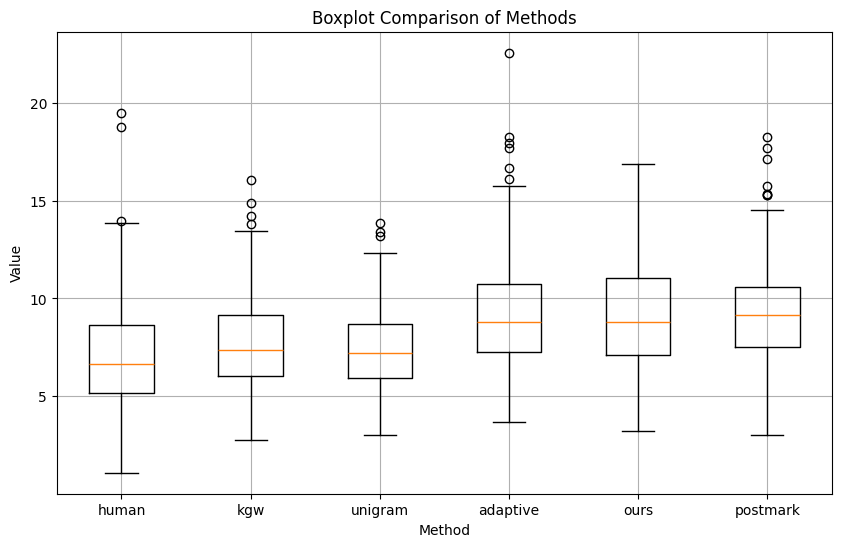

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

upper_bound = 100

alpha = 2.0
delta0, delta = 0.1, 0.13
wm_dataset = 'c4'
wm_model = 'Llama-3.1-8B-Instruct'

# Collect data from each method
data_dict = {}

for method, info in methods_info.items():
    path = info["path"].format(wm_model=wm_model, wm_dataset=wm_dataset, alpha=alpha, delta0=delta0, delta=delta)
    df = pd.read_csv(path)
    column = f'ppl_{info["column_name"]}'
    values = df[column].to_list()
    filtered_values = [v for v in values if v <= upper_bound]
    print(f'{method} filtered {len(values) - len(filtered_values)} values)')
    data_dict[method] = filtered_values


# Extract data and labels
data = list(data_dict.values())
labels = list(data_dict.keys())

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.xlabel("Method")
plt.ylabel("Value")
plt.title("Boxplot Comparison of Methods")
plt.grid(True)
plt.show()


# Tradeoff

In [112]:
label_size = 50

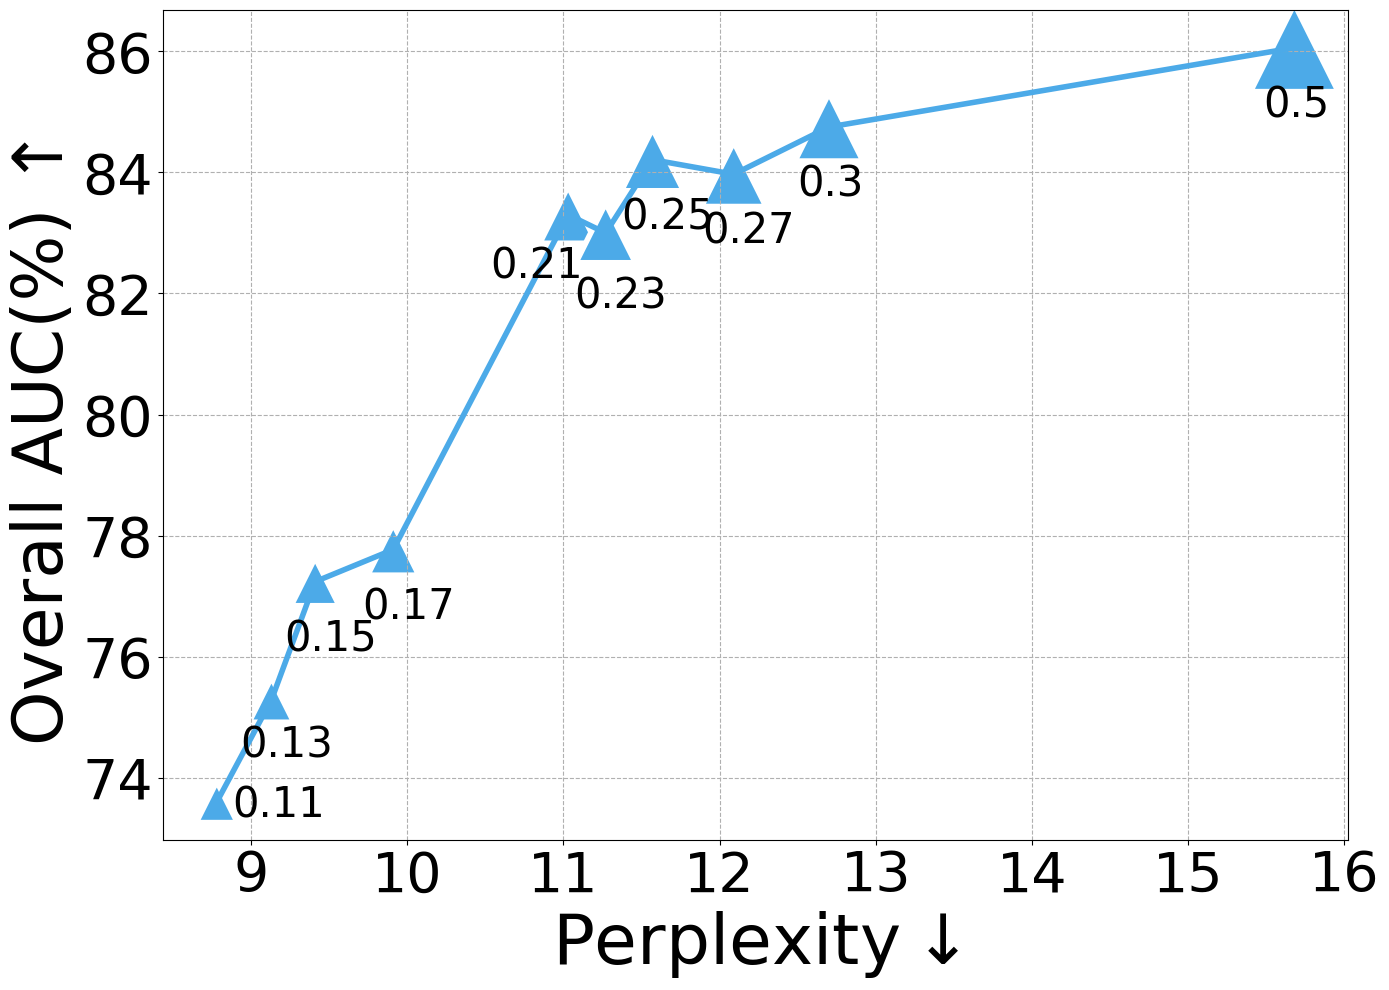

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = r"/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/tradeoff.csv"
df = pd.read_csv(data_path)

# 假设 df 已经定义且包含列: ['delta', 'perplexity', 'overall_auc']
df_sorted = df.sort_values(by='delta')

plt.figure(figsize=(14,10))

# 使用 delta 控制点的大小，这里乘以20作为缩放因子，你可以根据实际情况调整
sizes = df_sorted['delta'] * 8000

# plt.scatter(df_sorted['perplexity'], df_sorted['overall_auc'], 
            # s=sizes, c='#8bc3e8', marker='o', label='Data points')

# 绘制折线（按照 perplexity 和 overall_auc 顺序连接）
plt.plot(df_sorted['perplexity'], df_sorted['overall_auc'], 
         color='#4caae8', linestyle='-', linewidth=4)

# 绘制散点，点的大小根据 delta 值变化
plt.scatter(df_sorted['perplexity'], df_sorted['overall_auc'], 
            marker='^', s=sizes, c='#4caae8', edgecolors='w', linewidth=4)

# 可选：在每个点旁标注对应的 delta 值
for i in range(len(df_sorted)):
    delta_val = df_sorted['delta'].iloc[i]
    x = df_sorted['perplexity'].iloc[i] - 0.2
    y = df_sorted['overall_auc'].iloc[i] - 1.3
    if delta_val == 0.11:
        x += 0.3
        y += 0.9
    elif delta_val == 0.13:
        y += 0.2
    elif delta_val == 0.21:
        x -= 0.3
        y += 0.1
    elif delta_val == 0.23:
        y -= 0.1
    plt.text(x, y, f'{delta_val}', fontsize=30, ha='left', va='bottom')

plt.xticks(size=label_size-10)
plt.yticks(size=label_size-10)

plt.xlabel('Perplexity$\downarrow$', size=label_size)
plt.ylabel('Overall AUC(%) ↑ ', size=label_size)
plt.grid(True, linestyle='--')
# plt.title('PPL vs. AUC for Different Delta Values')
# plt.legend()
plt.tight_layout()
plt.show()



# Previx v.s. Global

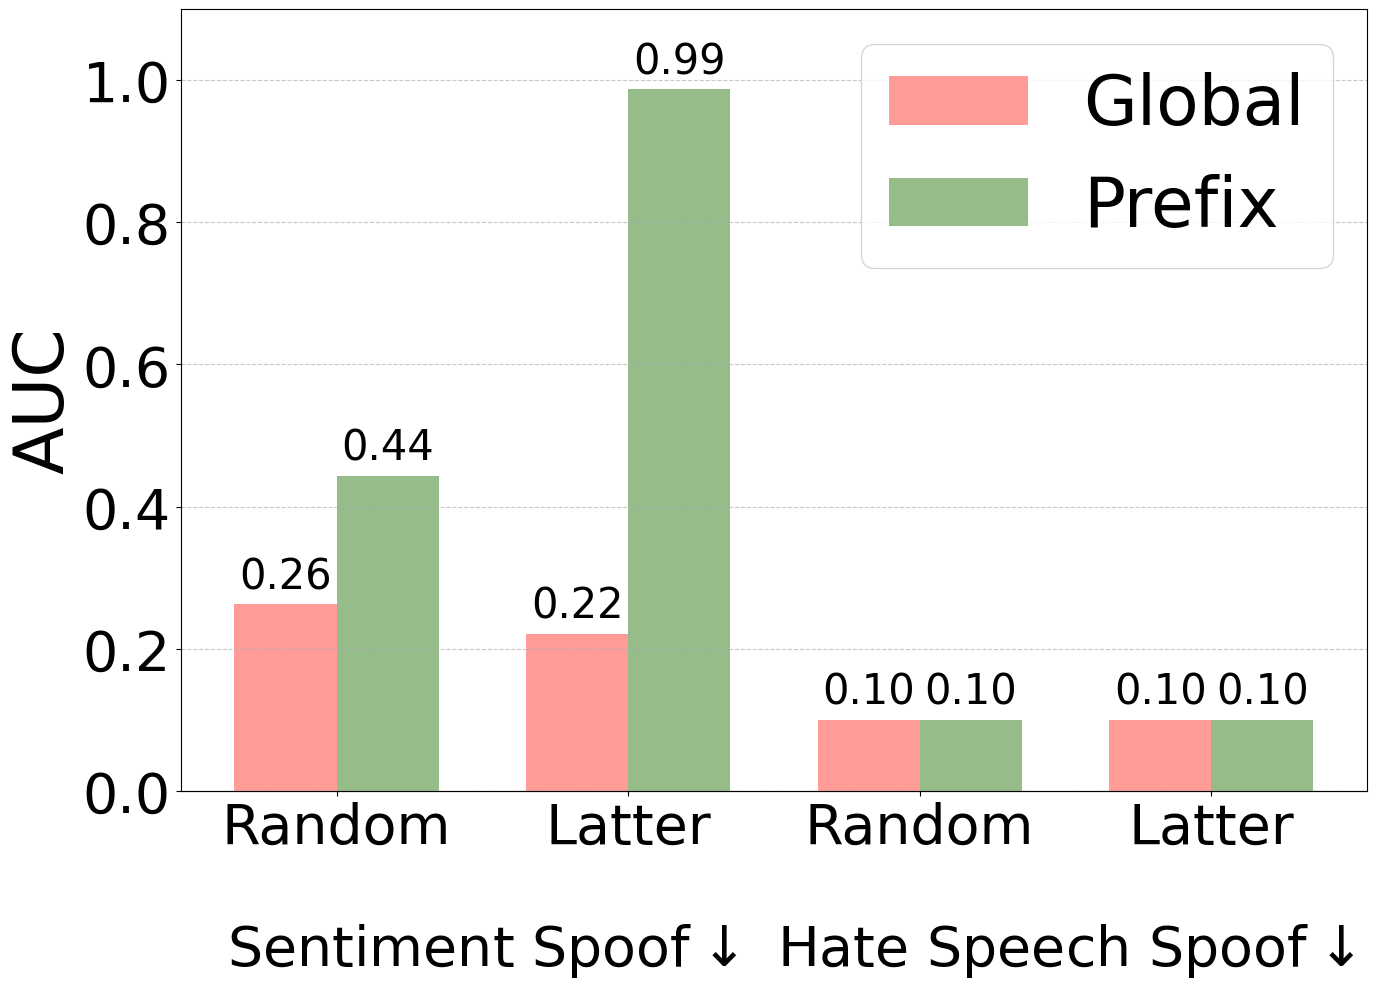

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = r"/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/prefix_global.csv"
df = pd.read_csv(path)

# 创建多级 x 轴索引（MultiIndex）
df['x_label'] = list(zip(df['attack'], df['position']))
df = df.sort_values(by=['attack', 'position'], ascending=False)

x_labels = df['x_label'].unique()
x = np.arange(len(x_labels))  # 主 x 轴的组数

bar_width = 0.35
methods = df['method'].unique()

# 配色
colors = {
    'Global': '#ff9c98',  # 浅粉
    'Prefix': '#95bc89'   # 浅绿
}

fig, ax = plt.subplots(figsize=(14,10))

# 画每个 method 的柱子
for i, method in enumerate(methods):
    auc_vals = []
    for label in x_labels:
        auc = df[(df['method'] == method) & (df['x_label'] == label)]['auc'].values[0]
        auc_vals.append(auc)
    ax.bar(x + i * bar_width, auc_vals, width=bar_width, label=method, color=colors[method])

# 设置两层 x 轴标签
x_tics = x + bar_width / 2
ax.set_xticks(x_tics)
ax.set_xticklabels(
    [pos if pos != 'Mark' else '' for atk, pos in x_labels], fontsize=10
)
ax.tick_params(axis='x', labelsize=label_size-10)
ax.tick_params(axis='y', labelsize=label_size-10)

# label the attack type:
sec = ax.secondary_xaxis(location=0)
sec_x_tics = x_tics.reshape(-1, 2).mean(axis=1)
sec.set_xticks(sec_x_tics, labels=['\n\nSentiment Spoof$\downarrow$', '\n\nHate Speech Spoof$\downarrow$'])
sec.tick_params(axis='x', labelsize=label_size-10, length=0)

# 添加数值标注
for i, method in enumerate(methods):
    for j, label in enumerate(x_labels):
        val = df[(df['method'] == method) & (df['x_label'] == label)]['auc'].values[0]
        ax.text(x[j] + i * bar_width, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=label_size-20)

# 设置标签、图例、网格
ax.set_ylabel('AUC', fontsize=label_size)
ax.legend(fontsize=label_size)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Backup

In [ ]:
import os
import re
import glob

root_path = "/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/outputs/"

wm_dataset_names = ['c4', 'lfqa']
is_prefix_ablation = False
prefix_ablation_folder = 'prefix-wm/' if is_prefix_ablation else ''
scores_prefix = ['adaptive', 'paraphrased', 'latter_spoofing']
scores = ['human_score'] + [f'{prefix}_watermarked_text_score' for prefix in scores_prefix]


results = []
for wm_dataset_name in wm_dataset_names:
    print(f'------- wm on {wm_dataset_name} -------')
    pattern = re.compile(rf"""
        .*/c4/(?P<model_name>[^/]+)/(?P<batch_size>\d+)batch_(?P<num_epoch>\d+)epochs/
        llama(?P<llama_para>\d+)gpt(?P<gpt_para>\d+)-sent1-latter_sent1-fact0-hate1/
        loss_cl(?P<cl_weight>[\d\.]+)-tl(?P<tl_weight>[\d\.]+)-wneg(?P<neg_weight>[\d\.]+)-margin(?P<margin>[\d\.]+)/
        (?P<wm_model>[^/]+)/{prefix_ablation_folder}
        wm-{wm_dataset_name}-alpha(?P<alpha>[\d\.]+)-delta(?P<delta_0>[\d\.]+)\|(?P<delta>[\d\.]+)\.csv$
    """, re.VERBOSE)

    # find mutual non-empty rows
    mutual_non_empty_indices = None
    for filepath in glob.iglob(root_path + "/**/*.csv", recursive=True):
        match = pattern.match(filepath)
        if match:
            df = pd.read_csv(filepath)
            if 'hate_watermarked_text_score' in df.columns:
                df['spoofing_watermarked_text_score'] = df['hate_watermarked_text_score']
            df = df[['human_score', 'adaptive_watermarked_text_score', 'paraphrased_watermarked_text_score', 'spoofing_watermarked_text_score']]
            non_empty_indices = set(df.dropna().index)
            print(f'Number of non-empty rows: {len(non_empty_indices)}')
            print(filepath)
            if mutual_non_empty_indices is None:
                mutual_non_empty_indices = non_empty_indices
            else:
                mutual_non_empty_indices = mutual_non_empty_indices.intersection(non_empty_indices)

    # get roc-auc results of mutual non-empty rows
    if mutual_non_empty_indices is not None:
        mutual_non_empty_indices = list(mutual_non_empty_indices)
        print(f'Number of mutual non-empty rows: {len(mutual_non_empty_indices)}')
        for filepath in glob.iglob(root_path + "/**/*.csv", recursive=True):
            match = pattern.match(filepath)
            if match:
                df = pd.read_csv(filepath)
                if 'hate_watermarked_text_score' in df.columns:
                    df['spoofing_watermarked_text_score'] = df['hate_watermarked_text_score']                    
                df = df[['human_score', 'adaptive_watermarked_text_score', 'paraphrased_watermarked_text_score', 'spoofing_watermarked_text_score']]
                df = df.loc[mutual_non_empty_indices]
                auc_result_dict = get_auc(df)

                result_dict = {'train_dataset_name': train_dataset_name, 'wm_dataset_name': wm_dataset_name}
                result_dict.update(match.groupdict())
                result_dict.update(auc_result_dict)
                results.append(result_dict)


==================== train on c4 ====================
------- wm on c4 -------
Number of mutual non-empty rows: 193


In [ ]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(root_path, 'roc_auc_results.csv'), index=False)

In [34]:
!pwd

/blue/buyuheng/li_an.ucsb/projects/watermark-simcse/watermarking/util
